#**Pfam Protein Sequence Classification with Tensorflow and Keras**


In this tutorial, we will attempt to develop a protein sequence classification model in which we will classify protein sequences based on their known family accession using the Pfam (https://pfam.xfam.org/) dataset.

Pfam: The protein families database in 2021: J. Mistry, S. Chuguransky, L. Williams, M. Qureshi, G.A. Salazar, E.L.L. Sonnhammer, S.C.E. Tosatto, L. Paladin, S. Raj, L.J. Richardson, R.D. Finn, A. Bateman
Nucleic Acids Research (2020) doi: 10.1093/nar/gkaa913

The Pfam dataset consists of several columns, as follows:
* *Family_id*: The name of the family that the seqeunce belongs to (for example, filamin).
* *Family Accession*: The class or output that our model will aim to predict.
* *Sequence*: The amino acid sequence we will use as input for our model

We will use the seqeunce data to develop model to determine each seqeunece's associated family accession. The sequences are in their raw state with different lengths and sizes. We will need to pre-process the data and structure it in such a way as to prepare it for sequence classification. We will develop a model using a *balanced* set of different labels to ensure the model does not learn any particular bias.

Adapted from Saleh Alkhalifa. [Machine Learning in Biotechnology and Life Sciences](https://github.com/PacktPublishing/Machine-Learning-in-Biotechnology-and-Life-Sciences).

###Install tensorflow and keras


**TensorFlow** is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community. 

**Keras** is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.



In [1]:
!pip install tensorflow keras --quiet

##Import libraries

In [2]:
import pandas as pd
import numpy as np

#Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os

##Download dataset

In [3]:
URL = "https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-in-Biotechnology-and-Life-Sciences/main/datasets/dataset_pfam/"

files = []
for i in range(8):
    df = pd.read_csv(URL+f"dataset_pfam_seq_sd{i+1}.csv", index_col=None, header=0)
    files.append(df)
    
df = pd.concat(files, axis=0, ignore_index=True)
df.shape

(1339080, 5)

In [4]:
# peek into the data
df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [5]:
# Check missing data
df.isna().sum()

family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
dtype: int64

In [6]:
# Get top 10 abundant family ids
df["family_id"].groupby(df["family_id"]).value_counts().nlargest(10)

family_id        family_id      
Methyltransf_25  Methyltransf_25    4545
LRR_1            LRR_1              2407
Acetyltransf_7   Acetyltransf_7     2199
His_kinase       His_kinase         1921
Bac_transf       Bac_transf         1908
Lum_binding      Lum_binding        1878
DNA_binding_1    DNA_binding_1      1681
Chromate_transp  Chromate_transp    1579
Lipase_GDSL_2    Lipase_GDSL_2      1564
DnaJ_CXXCXGXG    DnaJ_CXXCXGXG      1512
Name: family_id, dtype: int64

In [7]:
# Get top 10 abundant family accessions
df["family_accession"].groupby(df["family_accession"]).value_counts().nlargest(10)

family_accession  family_accession
PF13649.6         PF13649.6           4545
PF00560.33        PF00560.33          2407
PF13508.7         PF13508.7           2199
PF06580.13        PF06580.13          1921
PF02397.16        PF02397.16          1908
PF00677.17        PF00677.17          1878
PF01035.20        PF01035.20          1681
PF02417.15        PF02417.15          1579
PF13472.6         PF13472.6           1564
PF00684.19        PF00684.19          1512
Name: family_accession, dtype: int64

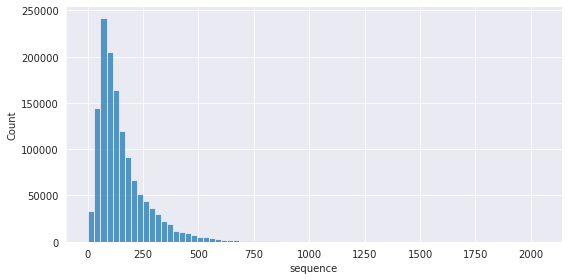

In [8]:
# Plot the sequence length frequency distribution
sns.displot(df["sequence"].apply(lambda x: len(x)), bins=75, height=4, aspect=2)

In [9]:
# Get mean sequence length
df["sequence"].str.len().mean()

155.15641783911343

In [10]:
# Get min sequence length
df["sequence"].str.len().min()

4

In [11]:
# Get max sequence length
df["sequence"].str.len().max()

2037

In [12]:
# Get median sequence length
df["sequence"].str.len().median()

119.0

In [13]:
# Get family accessions with counts more than 1200
df_filt = df.groupby("family_accession").filter(lambda x: len(x) > 1200)
df_filt

,family_id,sequence_name,family_accession,aligned_sequence,sequence
8,His_kinase,Q47E94_DECAR/372-450,PF06580.13,SE.I..KLLHAQVNPHFLFNALNTL......S....AV...I.......,SEIKLLHAQVNPHFLFNALNTLSAVIRRDPEKACHLVLNLSTFFRK...
29,Bac_transf,D3EZT3_CONWI/319-507,PF02397.16,KRTFDLIG.SL.....LLLT.L.L.S...P.L.L...L....T......,KRTFDLIGSLLLLTLLSPLLLTLSLAVKLSSRGPVFYRSTRPGIGG...
57,WD40,O48679_ARATH/318-354,PF00400.32,MSVVGA..L....R.....GH....RKA.............I...M...,MSVVGALRGHRKAIMCLAVASDLVLSGSADKSLRVWR
103,Glycos_trans_3N,A0A068Y394_ECHMU/7-69,PF02885.17,SGILSKKANG....G..SLSSTEIDYYTKEL..AE.DN...........,SGILSKKANGGSLSSTEIDYYTKELAEDNVNIAQIGAFLMAVFTRG...
120,Chromate_transp,D5EXG9_PRER2/4-187,PF02417.15,VSLFITFFEIGLFGFGGGYGML.SLIQHET........VE.........,VSLFITFFEIGLFGFGGGYGMLSLIQHETVEAHHWLSTSEFTDIVA...
...,...,...,...,...,...
1338917,DHH,R7FC58_9FIRM/344-498,PF01368.20,QVFL.MGHRFGDLDSIGS.ACGLAG........................,QVFLMGHRFGDLDSIGSACGLAGAVRLMRKPAYVVVSRQSCLATQL...
1338932,HTH_1,Q98N95_RHILO/3-62,PF00126.27,LEALADFNLVAAHG.GFGRAGR.ISGR...SKATLSRHVNELEH.S...,LEALADFNLVAAHGGFGRAGRISGRSKATLSRHVNELEHSLGVRLI...
1338989,MutS_III,I0IH70_PHYMF/275-582,PF05192.18,ASLASLEV.VR................TQAAAGA...............,ASLASLEVVRTQAAAGASGETAGSLLGVLSGNGKATRTPMGGRLLR...
1339027,Chromate_transp,R5XL48_9FIRM/4-177,PF02417.15,LKLFLSFLQIGLFSFGGGYAAM.PFIRDQV........VV.........,LKLFLSFLQIGLFSFGGGYAAMPFIRDQVVVQNSWLSMQEFTDLIT...


In [14]:
# Create a balanced dataset
df_bal = df_filt.groupby('family_accession').apply(lambda x: x.sample(1200))
df_bal.family_accession.value_counts()

PF00126.27    1200
PF00391.23    1200
PF13508.7     1200
PF13472.6     1200
PF06580.13    1200
PF05192.18    1200
PF03484.15    1200
PF03453.17    1200
PF02885.17    1200
PF02881.19    1200
PF02729.21    1200
PF02545.14    1200
PF02417.15    1200
PF02397.16    1200
PF01799.20    1200
PF01725.16    1200
PF01715.17    1200
PF01523.16    1200
PF01368.20    1200
PF01255.19    1200
PF01035.20    1200
PF00763.23    1200
PF00684.19    1200
PF00677.17    1200
PF00586.24    1200
PF00560.33    1200
PF00400.32    1200
PF13649.6     1200
Name: family_accession, dtype: int64

In [15]:
# Peek into the balanced dataset
df_bal.head()

family_id      sequence_name family_accession  \
family_accession                                                         
PF00126.27       381140      HTH_1  Q8NTT1_CORGL/7-66       PF00126.27   
                 1256875     HTH_1  Q88E41_PSEPK/3-62       PF00126.27   
                 864411      HTH_1    PERR_ECOLI/9-68       PF00126.27   
                 1175230     HTH_1    YKUM_BACSU/3-62       PF00126.27   
                 594219      HTH_1  C5AMM4_BURGB/9-67       PF00126.27   

                                                           aligned_sequence  \
family_accession                                                              
PF00126.27       381140   LEGLRYAQAVAETH.SFSAAAR.EYGV...TQPALSNGIAKLED.R...   
                 1256875  FKQLRSFIEVVHRG.GFTQAAQ.TLHI...SQSAVSKQVAQLEQ.D...   
                 864411   LNLLRAFEAAGRTG.AFALAAS.ELEL...SPSAISHAIRKLEN.L...   
                 1175230  LQELHMLVVLAEEL.NMRKAAE.RLFV...SQPALSQRLQTIEK.A...   
                 594219   LNLLVTLQALMTEK.HISRTAM.RLHK...SQPAISHALAHLRD.I...   

                                                                   sequence  
family_accession                                                             
PF00126.27       381140   LEGLRYAQAVAETHSFSAAAREYGVTQPALSNGIAKLEDRLGEQLF...  
                 1256875  FKQLRSFIEVVHRGGFTQAAQTLHISQSAVSKQVAQLEQDVGQPLL...  
                 864411   LNLLRAFEAAGRTGAFALAASELELSPSAISHAIRKLENLLDVRLF...  
                 1175230  LQELHMLVVLAEELNMRKAAERLFVSQPALSQRLQTIEKAWGTKIF...  
                 594219   LNLLVTLQALMTEKHISRTAMRLHKSQPAISHALAHLRDIFNDPLL...

In [16]:
# prepare input dataframe for modeling
# reset_index in pandas is used to reset index of the dataframe object to default indexing (0 to number of rows minus 1) 
# or to reset multi level index. By doing so, the original index gets converted to a column.
df_red = df_bal[["family_accession", "sequence"]].reset_index(drop=True)
df_red.head()

,family_accession,sequence
0,PF00126.27,LEGLRYAQAVAETHSFSAAAREYGVTQPALSNGIAKLEDRLGEQLF...
1,PF00126.27,FKQLRSFIEVVHRGGFTQAAQTLHISQSAVSKQVAQLEQDVGQPLL...
2,PF00126.27,LNLLRAFEAAGRTGAFALAASELELSPSAISHAIRKLENLLDVRLF...
3,PF00126.27,LQELHMLVVLAEELNMRKAAERLFVSQPALSQRLQTIEKAWGTKIF...
4,PF00126.27,LNLLVTLQALMTEKHISRTAMRLHKSQPAISHALAHLRDIFNDPLL...


In [17]:
# Compute num of unique classes
num_classes = len(df_red.family_accession.value_counts())
num_classes

28

In [18]:
# Get Pfam family accession unique number counts
df_red.family_accession.value_counts()

PF00126.27    1200
PF00391.23    1200
PF13508.7     1200
PF13472.6     1200
PF06580.13    1200
PF05192.18    1200
PF03484.15    1200
PF03453.17    1200
PF02885.17    1200
PF02881.19    1200
PF02729.21    1200
PF02545.14    1200
PF02417.15    1200
PF02397.16    1200
PF01799.20    1200
PF01725.16    1200
PF01715.17    1200
PF01523.16    1200
PF01368.20    1200
PF01255.19    1200
PF01035.20    1200
PF00763.23    1200
PF00684.19    1200
PF00677.17    1200
PF00586.24    1200
PF00560.33    1200
PF00400.32    1200
PF13649.6     1200
Name: family_accession, dtype: int64

In [19]:
# Split data into 75% X_train and 25% X_Test, among X_Test, 50% for validation(X_val) and 50% for test (X_test)
from sklearn.model_selection import train_test_split

X_train, X_Test = train_test_split(df_red, test_size=0.25)
X_val, X_test = train_test_split(X_Test, test_size=0.50)

In [20]:
# Get the train, test, and validation dataaset sizes
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(25200, 2)
(4200, 2)
(4200, 2)


In [22]:
# Create amino acid seqence dictionary
aa_seq_dict = {'A': 1,'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,'K': 9,'L': 10,'M': 11,'N': 12,'P': 13,'Q': 14,'R': 15,'S': 16,'T': 17,'V': 18,'W': 19,'Y': 20}

In [23]:
# Encode amino acid sequence using the dictionary above
def aa_seq_encoder(data):
    full_sequence_list = []
    for i in data['sequence'].values:
        row_sequence_list = []
        for j in i:
            row_sequence_list.append(aa_seq_dict.get(j, 0))
        full_sequence_list.append(np.array(row_sequence_list))
    return full_sequence_list
  
X_train_encode = aa_seq_encoder(X_train) 
X_val_encode = aa_seq_encoder(X_val) 
X_test_encode = aa_seq_encoder(X_test) 

In [22]:
# Show an example encoded amino acid sequence
X_train_encode[0]

array([ 9, 15, 10,  5,  3,  8, 10, 10,  1,  1,  8,  6, 10,  8, 10,  1,  1,
       13, 18, 11,  5, 10,  1,  1, 10,  1, 18, 15,  5,  3, 17, 13,  6, 13,
        8, 10,  5, 15, 14,  9, 15,  8,  6,  9,  3,  5, 15, 17,  5,  4, 10,
       10,  9,  5, 15, 16, 11, 15, 18,  1, 12,  1,  6, 16, 14, 18, 17,  5,
        6,  4,  3, 10, 15,  8, 17, 16, 16,  6, 15, 19, 10, 15,  9, 18,  9,
        5,  3,  4, 10, 13, 14, 10, 19, 12, 18, 10, 15,  6,  3, 11, 16,  5,
       18,  6, 13, 15, 13,  4, 18, 13, 14, 20, 18,  4, 10, 20, 15,  3, 15,
       20,  4,  9, 10, 10,  6, 18, 15, 13,  6,  8, 17,  3, 15,  1, 16,  8,
        9, 20, 15, 16,  4, 16,  1,  8, 10,  6, 16, 18,  3,  3, 13,  4, 12,
       20, 20, 15, 17, 18,  8, 10, 13,  3,  9,  8,  1, 11,  6,  4,  4, 20,
       18,  4, 15,  7, 16, 18, 18,  6,  3,  8,  6,  8,  8, 10, 14, 17, 18,
       10, 18, 18,  5,  9])

In [24]:
#Pad sequence to the same length of 100
from keras.preprocessing.sequence import pad_sequences

max_length = 100

X_train_padded = pad_sequences(X_train_encode, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_encode, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_encode, maxlen=max_length, padding='post', truncating='post')

In [25]:
X_train.sequence[1]

'FKQLRSFIEVVHRGGFTQAAQTLHISQSAVSKQVAQLEQDVGQPLLERQASHLHLTAAGR'

In [26]:
X_train_encode[1][:]

array([10,  5,  6,  4,  5,  5, 15, 18,  6, 16, 10, 18,  5,  6,  6,  6,  7,
       18, 18, 10, 13, 10, 10,  4, 17,  1, 18,  6,  3, 16, 11, 16,  6,  3,
       15,  5, 10, 17,  6, 20,  1,  5,  1, 14,  1, 18, 13,  6, 13, 11,  5,
       17,  5,  1, 17,  5, 10,  6,  1,  4, 11, 11, 10,  4, 12, 13,  5,  8,
        6,  1,  1,  8,  1, 17, 18,  1,  8,  5, 10, 13,  6,  5, 10, 10, 11,
       10, 18,  6, 10, 15, 16, 19,  7,  1,  8,  1,  1, 15, 13,  9, 11,  1,
        6, 11, 10,  1,  6, 18, 12,  1,  2, 18, 18,  6, 10, 10,  1,  1,  1,
       10, 20, 14, 13, 18,  5, 16, 14,  6, 18, 10, 16,  1, 18,  3, 11,  1,
        8, 18, 10,  8,  6,  5,  6,  1, 10,  9,  5,  5,  9, 13, 14, 11, 10,
       10, 10, 18, 10,  6,  5, 16, 18])

In [27]:
X_train_padded[1][:]

array([10,  5,  6,  4,  5,  5, 15, 18,  6, 16, 10, 18,  5,  6,  6,  6,  7,
       18, 18, 10, 13, 10, 10,  4, 17,  1, 18,  6,  3, 16, 11, 16,  6,  3,
       15,  5, 10, 17,  6, 20,  1,  5,  1, 14,  1, 18, 13,  6, 13, 11,  5,
       17,  5,  1, 17,  5, 10,  6,  1,  4, 11, 11, 10,  4, 12, 13,  5,  8,
        6,  1,  1,  8,  1, 17, 18,  1,  8,  5, 10, 13,  6,  5, 10, 10, 11,
       10, 18,  6, 10, 15, 16, 19,  7,  1,  8,  1,  1, 15, 13,  9],
      dtype=int32)

In [29]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels with value between 0 and n_classes-1.
le = LabelEncoder()

y_train_enc = le.fit_transform(X_train['family_accession'])
y_val_enc = le.transform(X_val['family_accession'])
y_test_enc = le.transform(X_test['family_accession'])

In [30]:
X_train['family_accession']

27403    PF03484.15
19520    PF02417.15
30926     PF13472.6
9462     PF00763.23
4367     PF00560.33
            ...    
10502    PF01035.20
25178    PF02885.17
32609     PF13649.6
18464    PF02397.16
5966     PF00586.24
Name: family_accession, Length: 25200, dtype: object

In [31]:
y_train_enc

array([22, 16, 25, ..., 27, 15,  4])

In [32]:
num_classes = len(le.classes_)
num_classes

28

In [33]:
# Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)
y_test = to_categorical(y_test_enc)

In [34]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
# Import tensorflow and keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model

In [36]:
# Build model
# Sequential groups a linear stack of layers into a tf.keras.Model.
# Sequential provides training and inference features on this model.
model = Sequential()

# EmbeddingLayer: Turns positive integers (indexes) into dense vectors of fixed size.
#  input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
#  output_dim: Integer. Dimension of the dense embedding.
#  input_length: Length of input sequences, when it is constant.
model.add(Embedding(21, 16, input_length=max_length, name="EmbeddingLayer"))
# Bidirectional wrapper for RNNs with 16 units of LSTM
model.add(Bidirectional(LSTM(16), name="BidirectionalLayer"))
# Applies Dropout to the input with 20% of the input units to drop.
model.add(Dropout(0.2, name="DropoutLayer"))
# densely-connected NN layer of 28 units
model.add(Dense(28, activation='softmax', name="DenseLayer"))

# Optimizer that implements the Adam algorithm
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Configures the model for training use 'Adam' as optimizer, 'categorical_crossentropy' 
# as loss funciton, and 'accuracy' as evaluation metrics
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 100, 16)           336       
                                                                 
 BidirectionalLayer (Bidirec  (None, 32)               4224      
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 32)                0         
                                                                 
 DenseLayer (Dense)          (None, 28)                924       
                                                                 
Total params: 5,484
Trainable params: 5,484
Non-trainable params: 0
_________________________________________________________________


In [37]:
from keras.callbacks import EarlyStopping

# Stop training when a monitored metric has stopped improving
# monitor: Quantity to be monitored.
# patience: Number of epochs with no improvement after which training will be stopped.
# verbose: verbosity mode on
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [38]:
# Trains the model for a fixed number of epochs (iterations on a dataset)
history = model.fit(
    X_train_padded, y_train,
    epochs=100, batch_size=256,
    validation_data=(X_val_padded, y_val),
    callbacks=[es]
    )

Epoch 1/100
99/99 [==============================] - 9s 20ms/step - loss: 1.8332 - accuracy: 0.4311 - val_loss: 0.9708 - val_accuracy: 0.6895
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.6997 - accuracy: 0.7884 - val_loss: 0.3673 - val_accuracy: 0.8969
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.3923 - accuracy: 0.8852 - val_loss: 0.2086 - val_accuracy: 0.9476
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.2616 - accuracy: 0.9246 - val_loss: 0.1563 - val_accuracy: 0.9595
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.2095 - accuracy: 0.9397 - val_loss: 0.1105 - val_accuracy: 0.9719
Epoch 6/100
99/99 [==============================] - 1s 12ms/step - loss: 0.1528 - accuracy: 0.9570 - val_loss: 0.0940 - val_accuracy: 0.9764
Epoch 7/100
99/99 [==============================] - 1s 12ms/step - loss: 0.1388 - accuracy: 0.9603 - val_loss: 0.0809 - val_accuracy: 0.9760
Epoch 

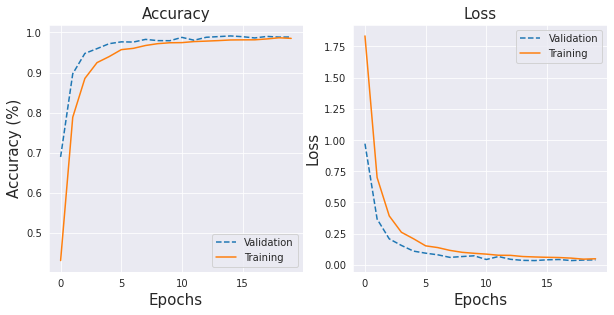

In [39]:
# Plot accurcy and loss across epochs
fig = plt.figure(figsize=(10,10))

# total_rows, total_columns, subplot_index(1st, 2nd, etc..)
plt.subplot(2, 2, 1)
plt.title("Accuracy", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy (%)", fontsize=15)
plt.plot(history.history["val_accuracy"], label='Validation Accuracy', linestyle='dashed')
plt.plot(history.history["accuracy"], label='Training Accuracy')
plt.legend(["Validation", "Training"], loc="lower right")

plt.subplot(2, 2, 2)
plt.title("Loss", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.plot(history.history["val_loss"], label='Validation loss', linestyle='dashed')
plt.plot(history.history["loss"], label='Training loss')
plt.legend(["Validation", "Training"], loc="upper right")

In [40]:
from sklearn.metrics import classification_report

# Generates output predictions for the input samples
y_pred = model.predict(X_test_padded)

# Build a text report showing the main classification metrics
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=le.classes_))

              precision    recall  f1-score   support

  PF00126.27       0.99      0.99      0.99       150
  PF00391.23       1.00      0.98      0.99       161
  PF00400.32       1.00      0.99      1.00       148
  PF00560.33       0.99      1.00      1.00       134
  PF00586.24       0.99      0.99      0.99       154
  PF00677.17       0.97      1.00      0.98       155
  PF00684.19       1.00      1.00      1.00       143
  PF00763.23       0.99      0.97      0.98       151
  PF01035.20       1.00      0.97      0.99       150
  PF01255.19       0.99      0.99      0.99       158
  PF01368.20       1.00      1.00      1.00       167
  PF01523.16       0.97      0.97      0.97       149
  PF01715.17       0.99      1.00      1.00       145
  PF01725.16       0.99      0.99      0.99       139
  PF01799.20       0.99      0.99      0.99       139
  PF02397.16       1.00      0.99      1.00       151
  PF02417.15       0.96      0.99      0.98       158
  PF02545.14       0.99    

**Support** is the number of actual occurrences of the class in the specified dataset. **macro avg** takes the arithmetic mean (aka unweighted mean). **weighted avg** takes the mean of all per-class while considering each class’s support.

In [41]:
# Show predicted values
y_pred

array([[2.59288946e-09, 2.06379749e-08, 1.46393664e-09, ...,
        8.36897662e-09, 4.90818422e-07, 3.27870886e-08],
       [1.55446457e-06, 1.01020414e-04, 6.96098823e-08, ...,
        3.05156505e-06, 4.08188157e-07, 5.31112448e-07],
       [8.24429525e-10, 3.08059619e-11, 6.78153755e-09, ...,
        1.03973960e-07, 1.09964837e-08, 4.11169503e-06],
       ...,
       [1.32514642e-11, 1.88467666e-12, 2.08311657e-09, ...,
        4.69216729e-06, 2.10570575e-10, 8.98834742e-07],
       [3.10625858e-09, 1.92015381e-08, 1.53572953e-11, ...,
        2.22001506e-09, 2.60413827e-07, 9.98883891e-08],
       [2.50251055e-08, 8.08663913e-07, 1.85465199e-09, ...,
        6.44444853e-08, 7.25207627e-08, 1.36724509e-09]], dtype=float32)

In [42]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix to evaluate the accuracy of a classification
cf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

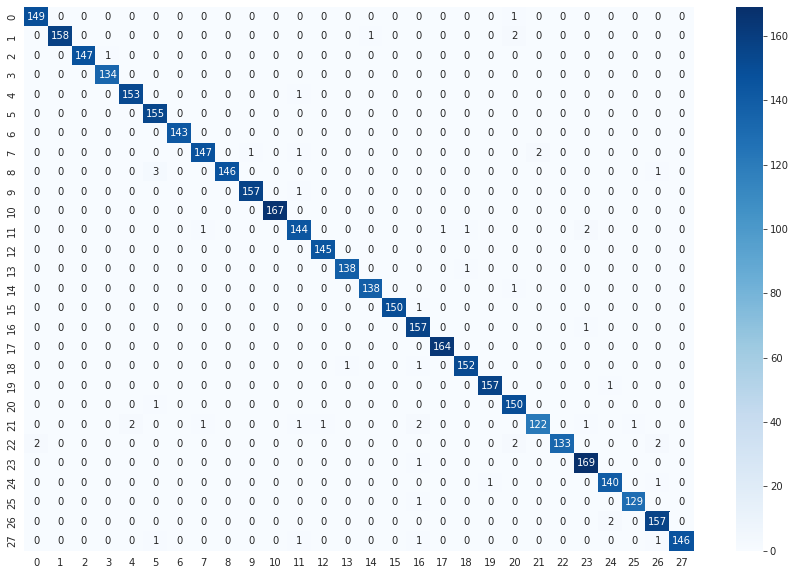

In [43]:
# Plot confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')